<a href="https://colab.research.google.com/github/seacatgm/-/blob/main/Classification/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F%20%D0%B0%D1%83%D0%B4%D0%B8%D0%BE/librosa%2C_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Лайт 1 вариант

In [ ]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras import utils #Для to_categorical
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков
#Отрисовка графиков в ячейках collab
%matplotlib inline 
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax #Оптимизатор для задания шага обучения
from tensorflow.keras.models import Sequential, Model #Два формата модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D #Базовые слови
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
#Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile #Для разархивации базы

!unzip -q '/content/drive/My Drive/neuro/base/genres.zip' #распаковываем архив на google диске на локальный диск google colaboratory 

genres = os.listdir('genres') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда

    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 106c
Жанр reggae готов -> 106c
Жанр jazz готов -> 104c
Жанр rock готов -> 106c
Жанр pop готов -> 105c
Жанр classical готов -> 104c
Жанр metal готов -> 104c
Жанр hiphop готов -> 105c
Жанр disco готов -> 105c
Жанр country готов -> 104c


In [ ]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(X_train[0])

[ 2.13155555  0.33742716  0.22028001  0.44212648  0.50457794  1.40690107
 -0.21196296 -0.74655637  0.53333472 -0.79525875  1.45504473 -1.30020549
  1.76880078 -0.3898873   0.87429719 -1.30268541  1.52985753 -1.75157715
  1.55115831 -2.24106976  0.20098409 -2.16642286  0.79032646 -0.96896914
 -0.14472764 -0.06767518  0.16707541  0.0134225   1.99401499  0.13080865
 -0.24895696  0.66408532  0.26330643 -0.3737008  -0.49191296  2.15119835
  0.26137443]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


Epoch 1/400
45/45 [==============================] - 3s 24ms/step - loss: 2.8260 - accuracy: 0.1269 - val_loss: 1.7942 - val_accuracy: 0.3600
Epoch 2/400
45/45 [==============================] - 1s 12ms/step - loss: 2.1673 - accuracy: 0.2530 - val_loss: 1.5388 - val_accuracy: 0.4400
Epoch 3/400
45/45 [==============================] - 1s 12ms/step - loss: 1.9610 - accuracy: 0.3695 - val_loss: 1.3850 - val_accuracy: 0.4400
Epoch 4/400
45/45 [==============================] - 1s 12ms/step - loss: 1.7744 - accuracy: 0.4026 - val_loss: 1.2890 - val_accuracy: 0.4700
Epoch 5/400
45/45 [==============================] - 1s 12ms/step - loss: 1.8284 - accuracy: 0.3856 - val_loss: 1.2206 - val_accuracy: 0.5000
Epoch 6/400
45/45 [==============================] - 1s 12ms/step - loss: 1.7416 - accuracy: 0.4153 - val_loss: 1.1831 - val_accuracy: 0.5400
Epoch 7/400
45/45 [==============================] - 1s 12ms/step - loss: 1.6322 - accuracy: 0.4536 - val_loss: 1.1731 - val_accuracy: 0.5700
Epoch 

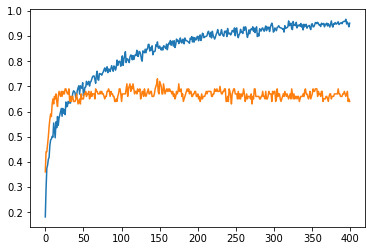

In [ ]:
indexes = range(0,37)

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(600, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(400, activation='elu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(200, activation='selu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(100, activation='selu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=400,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()